## <a class="anchor" id="head">Social vulnerability and Covid-19 in Chile</a>

[Part I: A first look at the DataFrames](#first-look)

[Part II: Covid-19 in Chile](#part-ii)
    1. Covid-19 in Chile and worldwide
    2. Timeline of Covid-19 cases and deaths in Chile 
    3. Which are the 10 most affected districts in Chile, regarding cases and deaths

[Part III: Analyze the CASEN data: The ten most affected districts](#part-iii)
    1. Correlation between the CASEN social indicators and cases/deaths in the ten most affected districts
    2. Analyze six selected CASEN social indicators for the ten most affected districts
    3. Correlation between six selected CASEN social indicators and cases/deaths for most affected districts

[Part IV: Analyze the CASEN data: The ten less affected districts](#part-iv)
    1. Correlation between the CASEN social indicators and cases/deaths in the ten less affected districts
    2. A closer look at the indicators with the highest correlation for the ten less affected districts 

[Part V: Plot CASEN data vs. Covid-19 cases/deaths](#part-v)
    1. Scatterplot for Covid-19 cases
    2. Scatterplot for Covid-19 deaths

[Part VI: Predict Covid-19 cases/deaths applying a Machine Learning model to CASEN data](#part-vi)

In [1]:
# Read in libraries
import pandas as pd
pd.options.mode.chained_assignment = None  

import numpy as np

from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


# Read in CASEN data about social vulnerability
casen = pd.read_stata('Casen 2017.dta', convert_categoricals = False)

# Read in data about Covid-19 cases and deaths in Chilean regions
cases_regions = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto3/CasosTotalesCumulativo_T.csv',
    parse_dates = True)

deaths_regions = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto14/FallecidosCumulativo_T.csv',
    parse_dates = True)

# Read in data about Covid-19 in Chilean districts
cases_districts = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19.csv')
cases_districts = cases_districts[~cases_districts.Comuna.str.contains('Desconocido')]

deaths_districts = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto38/CasosFallecidosPorComuna.csv')
deaths_districts = deaths_districts[~deaths_districts.Comuna.str.contains('Desconocido')]
deaths_districts = deaths_districts[~deaths_districts.Comuna.str.contains('Total')]



# Read in data about Covid-19 worldwide
csse_cases_all = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

csse_all_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/07-27-2020.csv')

csse_deaths_all = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [2]:
# Read in World Bank data about population
worldbank_population = pd.read_csv('API_SP.POP.TOTL_DS2_en_csv_v2_1217749.csv', skiprows = range(3))
worldbank_population = worldbank_population.iloc[:, [0, 1, -2]]

# Unforunately, the World Bank country names are not in all cases the same as the CSSE country names. Therefore
# some renaming is necessary. 
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('United States', 'US')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Yemen, Rep.', 'Yemen')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Myanmar', 'Burma')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('St. Kitts and Nevis', 'Saint Kitts and Nevis')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Syrian Arab Republic', 'Syria')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Venezuela, RB', 'Venezuela')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Slovak Republic', 'Slovakia')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('St. Vincent and the Grenadines', 'Saint Vincent and the Grenadines')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('St. Lucia', 'Saint Lucia')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Russian Federation', 'Russia')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Kyrgyz Republic', 'Kyrgyzstan')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Korea, Rep.', 'Korea, South')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Iran, Islamic Rep.', 'Iran')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Gambia, The', 'Gambia')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Egypt, Arab Rep.', 'Egypt')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Czech Republic', 'Czechia')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Congo, Dem. Rep.', 'Congo (Kinshasa)')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Congo, Rep.', 'Congo (Brazzaville)')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Brunei Darussalam', 'Brunei')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Bahamas, The', 'Bahamas')


In [3]:
# Select only 46 relevant indicators from the CASEN study, such as poverty, access to health institutions or
# number of persons in household. 

casen_columns = ['region', 'provincia', 'comuna', 'e1', 'e6a', 'o1', 'o12', 'o16', 'o25a_min',
                'o25c', 'o28', 'y21a', 'y22a', 'y24', 'y27a', 'ysub', 'ytot', 's12', 's13', 's14', 
                's26a', 's27a', 's28', 's31a1', 's32c', 's33g1', 's33i1', 's33j1',
                'r1a', 'r3', 'r7c', 'r8a', 'r8b', 'r16a', 'r16b', 'v33', 'v37a', 'v37c',
                'v37i', 'v39b', 'pobreza', 'hh_d_prevs', 'hh_d_cot', 'hh_d_servbas', 'qaut', 'numper']

casen_rel = casen[casen_columns]

# Important question: There are a lot of NaNs in the CASEN data. How to handle them? 
# Options: Fill with mean, fill with median, drop (would leave not DataFrame)


## <a class="anchor" id="first-look">Part I: A first look at the DataFrames</a>

[Go to index](#head)

A first look at the DataFrames shows that the CASEN data has a lot of NaNs. E.g. the variable s32c ('Do you have difficulties with moving within your house?') has a very high percentage of NaNs. Other possible variables (option 2 and 3 for 'permament conditions'), that I found interesting at first, had more than 97% of NaNs which is why I dropped them.  

Interestingly, other indicators that are about not having enough money to buy food or having a water heater at home have the same share of NaNs, which is 67%. 

In [4]:
def first_look(lst):
    """
    Provides useful information about a list of dataframes: Name, Shape, NaNs and describe().
    
    Input: 
        lst(List): List of DataFrames
    
    Output: 
        Prints name, shape, share of NaNs, describe()
    """
    for item in lst:
        def get_df_name(df):
            name =[x for x in globals() if globals()[x] is df][0]
            return name
        print('Information for DataFrame ' + get_df_name(item))
        print('The shape of this DataFrame is {}.'.format(item.shape))
        print('NaN share for each column:')
        print((np.sum(item.isna() == True))/item.shape[0])
        print('Describe() for each column:')
        print(item.describe())
        print('---')

In [5]:
df_list = [casen_rel, cases_regions, deaths_regions, cases_districts, deaths_districts, csse_cases_all, csse_deaths_all]

first_look(df_list)

Information for DataFrame casen_rel
The shape of this DataFrame is (216439, 46).
NaN share for each column:
region          0.000000
provincia       0.000000
comuna          0.000000
e1              0.191107
e6a             0.000000
o1              0.191107
o12             0.573011
o16             0.682913
o25a_min        0.573011
o25c            0.625299
o28             0.191107
y21a            0.615448
y22a            0.000000
y24             0.672203
y27a            0.191107
ysub            0.712524
ytot            0.331424
s12             0.000000
s13             0.000000
s14             0.615448
s26a            0.000000
s27a            0.000000
s28             0.000000
s31a1           0.000000
s32c            0.881713
s33g1           0.191107
s33i1           0.191107
s33j1           0.191107
r1a             0.000000
r3              0.000000
r7c             0.672203
r8a             0.672203
r8b             0.672203
r16a            0.672203
r16b            0.672203
v33             0

Region           0.000000
Codigo region    0.000000
Comuna           0.000000
Codigo comuna    0.000000
Poblacion        0.000000
2020-03-30       0.008671
2020-04-01       0.000000
2020-04-03       0.000000
2020-04-06       0.000000
2020-04-08       0.000000
2020-04-10       0.000000
2020-04-13       0.000000
2020-04-15       0.000000
2020-04-17       0.000000
2020-04-20       0.000000
2020-04-24       0.000000
2020-04-27       0.000000
2020-05-01       0.000000
2020-05-04       0.000000
2020-05-08       0.000000
2020-05-11       0.000000
2020-05-15       0.000000
2020-05-18       0.000000
2020-05-22       0.000000
2020-05-25       0.000000
2020-05-29       0.000000
2020-06-01       0.000000
2020-06-05       0.000000
2020-06-08       0.000000
2020-06-12       0.000000
2020-06-15       0.000000
2020-06-19       0.000000
2020-06-23       0.000000
2020-06-28       0.000000
2020-07-01       0.000000
2020-07-05       0.000000
2020-07-10       0.000000
2020-07-13       0.000000
2020-07-17  

              Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  266.000000  266.000000  266.000000  266.000000  266.000000  266.000000   
mean    21.076624   22.829441    2.086466    2.458647    3.537594    5.390977   
std     24.904600   70.191330   27.279200   27.377862   34.083035   47.434934   
min    -51.796300 -135.000000    0.000000    0.000000    0.000000    0.000000   
25%      6.677575  -15.277675    0.000000    0.000000    0.000000    0.000000   
50%     22.820850   20.921188    0.000000    0.000000    0.000000    0.000000   
75%     41.143200   77.913685    0.000000    0.000000    0.000000    0.000000   
max     71.706900  178.065000  444.000000  444.000000  549.000000  761.000000   

           1/26/20      1/27/20      1/28/20      1/29/20  ...       7/26/20  \
count   266.000000   266.000000   266.000000   266.000000  ...  2.660000e+02   
mean      7.962406    11.003759    20.969925    23.180451  ...  6.113239e+04   
std      66.289178    89.31375

## <a class="anchor" id="part-ii">Part II: Covid-19 in Chile</a>

[Go to index](#head)

###     A. Covid-19 in Chile and worldwide

First, lets have a look at the spread of Covid-19 in Chile and worldwide. Therefore, we compare the number of cases and deaths per 100.000 habitants. 

In [6]:
def plot_covid_worldwide(df, title, country, m, z=100000, t=100000):
    """
    Function to plot a comparison between the m-most affected countries (as per z habitants) 
    and a specific country, which is highlighted in red. 
    
    If the specific country is not wihtin the m-most affected countries, it is appended at the end. 
    
    Input: 
        df (DataFrame): DataFrame with country data
        title (string): Specify the kind of the plot (cases or deaths) 
        country (string): The country that sould be highlighted
        m (int): Returns the m-most affected countries. 
        z (int): Number to calculate the cases per z habitants
        t (int): Number of minimal population for a country to be considered (standard: 100.000)
        
    Output: 
        A seaborn plot. 
    """
    
    # Get the relevant columns of df (Countryname and total number) and add a new column
    # of cases/deaths per z habitants. Rename the columns. 
    df_current = df.iloc[:, [1, -1]]
    df_current.columns = ['Country', title]

    # Merge World Bank population data with DataFrame
    df_final = df_current.merge(worldbank_population, left_on = 'Country', right_on = 'Country Name', how = 'left')
    df_final = df_final.drop(['Country Name', 'Country Code'], axis = 1)
    df_final.columns = ['Country', title, 'population']

    # Calculate cases per z habitants
    df_final.loc[:, 'per {} habitants'.format(z)] = (df_final.loc[:, title] / df_final.loc[:, 'population']) * z

    # Drop rows of countries that are below z
    rows_to_drop = []

    for i in range(len(df_final.population)):
        if df_final.population[i] < t:
            rows_to_drop.append(i)

    df_final = df_final.drop(rows_to_drop, axis = 0)


    # Groupby country and get the m-most affected countries. 
    df_final = df_final.groupby(
        'Country')[
        'per {} habitants'.format(z)].sum().reset_index().sort_values([
        'per {} habitants'.format(z)], ascending = False)
    
    # Show only the top m countries
    df_final_head = df_final.head(m)

    # Check if specific country is part of the m-most affected countries
    if country in list(df_final_head.Country) == True:

        # Get index of specific country in country list
        index = list(df_final_head.Country).index(country)

        # Plot the figure
        f = plt.figure(figsize = (16, 10))
        ax = f.add_subplot(1,1,1)

        ax = sns.barplot(y = df_final_head['Country'], x = df_final_head['per 100.000'], color = 'darkgrey')
        plt.ylabel('Country', fontsize = 12)
        plt.xlabel('{} per {} habitants'.format(title, z), fontsize = 12)
        plt.title('Covid-19 {} per {} habitants worldwide'.format(title, z), fontsize = 12)
        ax.get_children()[index].set_color('darkred') 

        plt.tick_params(labelsize=12)

        plt.grid(False)
        ax.xaxis.grid()
        sns.despine()
        plt.show()


    # If the specific country is not within the m-most affected countries, append it to the list
    else:

        df_final_head = df_final_head.append(df_final[df_final['Country'] == country])
        index = list(df_final_head.Country).index(country)

        f = plt.figure(figsize = (16, 10))
        ax = f.add_subplot(1,1,1)

        ax = sns.barplot(y = df_final_head['Country'], x = df_final_head['per {} habitants'.format(z)], color = 'darkgrey')
        plt.ylabel('Country', fontsize = 12)
        plt.xlabel('{} per {} habitants'.format(title, z), fontsize = 12)
        plt.title('Covid-19 {} per {} habitants worldwide'.format(title, z), fontsize = 12)
        ax.get_children()[index].set_color('darkred') 

        plt.tick_params(labelsize=12)

        plt.grid(False)
        ax.xaxis.grid()
        sns.despine()
        plt.show()

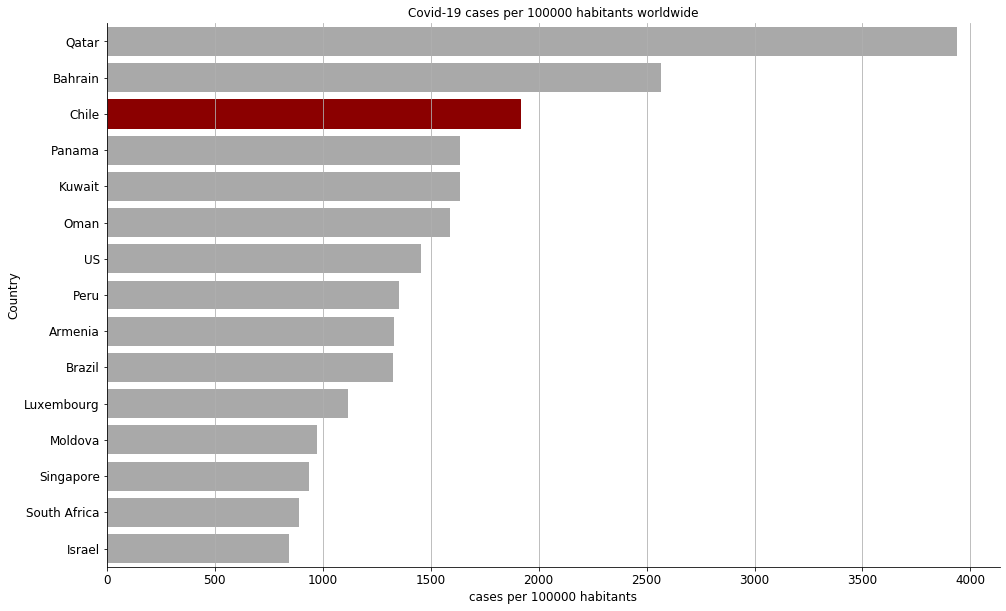

In [7]:
plot_covid_worldwide(csse_cases_all, 'cases', 'Chile', 15, 100000, 100000)

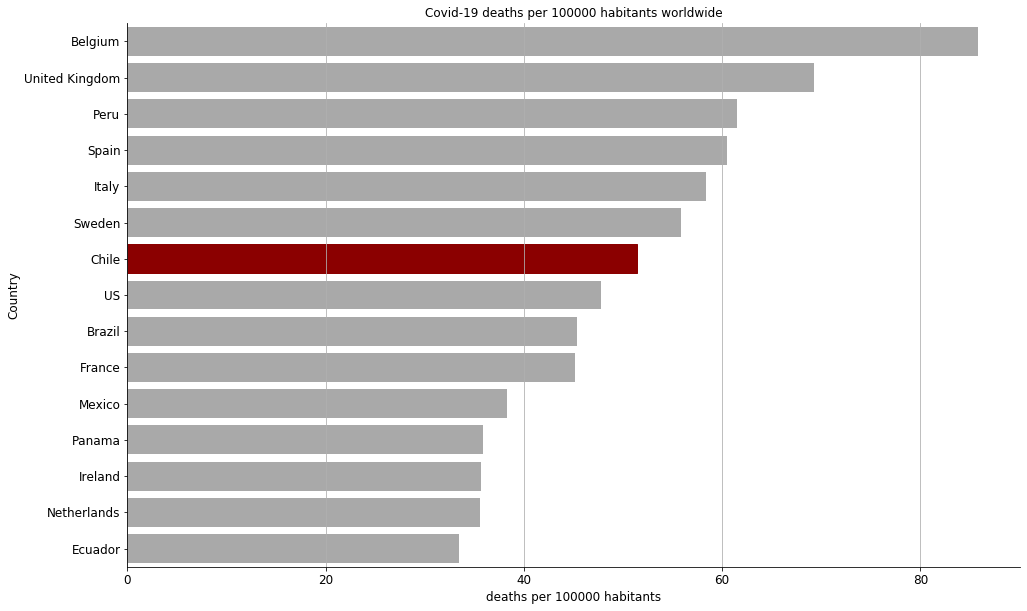

In [8]:
plot_covid_worldwide(csse_deaths_all, 'deaths', 'Chile', 15, 100000, 100000)

### B. Timeline of Covid-19 cases and deaths in Chile 

Next, we will focus on the situation in Chile. Chile is separated into 16 different regions, where "Metropolitana" is the region where the capital Santiago de Chile is located. It becomes clear that the Metropolitan Region is by far most affected by Covid-19.

However, other regions, just like Valparaíso (close to Santiago) and Antofagasta (in the north) experienced a very high rise in cases and deaths. 

In [9]:
def timeline_plot(df, title):
    """
    A function to plot a seaborn diagram which shows the development of Covid-19 data in Chile. 
    For better readability, the function returns a log scale plot. 
    
    Input: 
        df (DataFrame): A transposed DataFrame where the first row (not the index) is the date and the columns are the 
        regions. 
        title (string): Specify the kind of the plot (cases or deaths) 
        
    Output: 
        A seaborn plot. 
    """

    # Transform wide dataframe to long dataframe 
    df_melt = pd.melt(
        df, id_vars = 'Region', 
        value_vars = df.columns.drop('Region'),
        var_name='Regions', 
        value_name='Cases'
    )

    # Apply pandas to datetime and rename column for better understanding
    df_melt['Region'] = pd.to_datetime(df_melt['Region'], format = '%Y-%m-%d')
    df_melt = df_melt.rename(columns = {'Region': 'Date'}).sort_values('Cases', ascending = False)

    # Make a plot 
    f, ax = plt.subplots(figsize = (16, 10))
    g = sns.lineplot(
        df_melt.Date, 
        df_melt.Cases, 
        hue = df_melt.Regions
    )

    plt.xlabel('Date', fontsize = 12)
    plt.ylabel('{}'.format(title), fontsize = 12)
    plt.title('Covid-19 {} in Chile (log scale)'.format(title), fontsize = 12)
    
    plt.tick_params(labelsize=12)
    ax.yaxis.tick_right()
    ax.set_yscale('log')


    plt.grid(False)
    ax.yaxis.grid()
    sns.despine()
    plt.show()
            

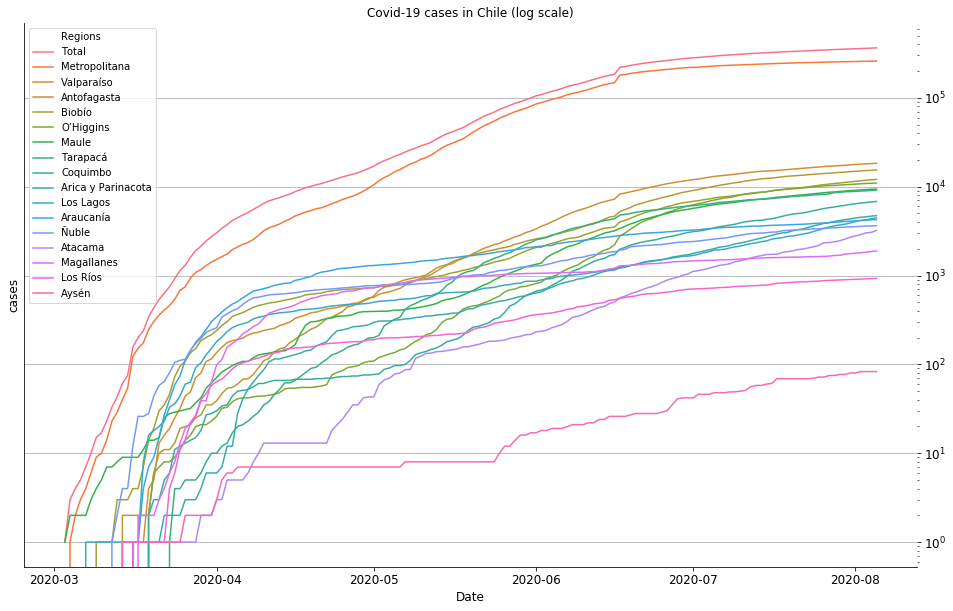

In [10]:
timeline_plot(cases_regions, 'cases')

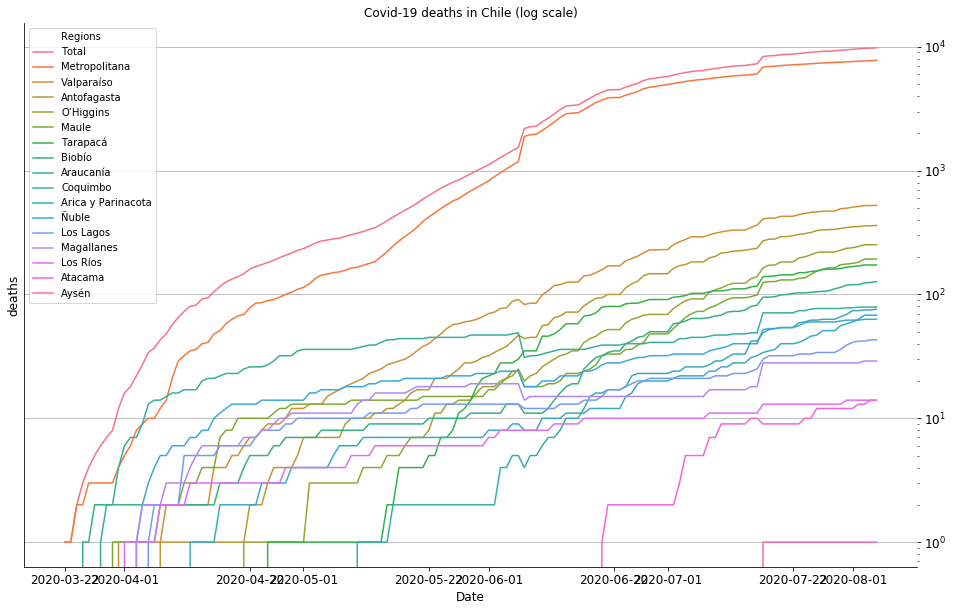

In [11]:
timeline_plot(deaths_regions, 'deaths')

###     B. Which are the 10 most affected districts in Chile, regarding cases and deaths

Looking at the most affected districts in Chile, it is no surprise that they are mainly located in the capital metropolitan zone. 

In [12]:
def get_affected_districts(df, title, m, n=100):
    """
    Function to get the m most or less affected districts. If m is negative, it returns the 10 less affected
    districts. Given that there are still some remote Chilean districts with 0 or only a few Covid-19 cases
    (Antarctic, Easter Islands), I chose a threshold of minimum n cases/deaths to be considered. 
    
    Input: 
        df (DataFrame): DataFrame with information about districts and numbers of cases/deaths
        title (string): Specify the kind of the data (cases or deaths)
        m (int): Returns the m most affected districts, if m is postitive and the m less affected districts
                 if m is negative. If m == 0, it returns a sorted DataFrame of all districts.
        n (int): Threshold of minimum number of cases/deaths 
        
    Output:
        affected (DataFrame): DataFrame with the m most or less affected districts
    """

    # Get the relevant columns from dataframe and rename them
    df_relevant = df.iloc[:, [0, 2, 3, -2]]
    df_relevant.columns = ['Region', 'District', 'District ID', title]
    
    # If m is positive, return the most affected districts. If m is negative, return the less affected districts.
    # If m == 0, return the whole list. 
    
    if m > 0:    
        
        # Group by District and drop "index" column
        affected = df_relevant.groupby(
            'District').agg({
            'Region': 'max',
            'District ID': 'max',
            title: 'sum'}).reset_index().sort_values(
            title, ascending = False).head(m).reset_index()

        affected = affected.drop(['index'], axis = 1)  

    if m < 0:
        
        # Consider only the districts with more than 10 cases/deaths: 
        df_relevant = df_relevant[df_relevant[df_relevant.columns[-1]] >= n]
        
        # Group by District and drop "index" column
        affected = df_relevant.groupby(
            'District').agg({
            'Region': 'max',
            'District ID': 'max',
            title: 'sum'}).reset_index().sort_values(
            title, ascending = False).tail(m*(-1)).reset_index()

        affected = affected.drop(['index'], axis = 1)  
    
    if m == 0: 
        
        # Group by District and drop "index" column
        affected = df_relevant.groupby(
            'District').agg({
            'Region': 'max',
            'District ID': 'max',
            title: 'sum'}).reset_index().sort_values(
            title, ascending = False).reset_index()

        affected = affected.drop(['index'], axis = 1)  
        
        
    return affected

In [13]:
get_affected_districts(cases_districts, 'cases', 10, 100)

,District,Region,District ID,cases
0,Puente Alto,Metropolitana,13201.0,22466.0
1,Santiago,Metropolitana,13101.0,14648.0
2,Maipu,Metropolitana,13119.0,14243.0
3,La Florida,Metropolitana,13110.0,13357.0
4,Penalolen,Metropolitana,13122.0,11560.0
5,San Bernardo,Metropolitana,13401.0,10883.0
6,La Pintana,Metropolitana,13112.0,9958.0
7,Pudahuel,Metropolitana,13124.0,9559.0
8,Quilicura,Metropolitana,13125.0,8895.0
9,Recoleta,Metropolitana,13127.0,8325.0


In [14]:
get_affected_districts(deaths_districts, 'deaths', 10, 100)

,District,Region,District ID,deaths
0,Puente Alto,Metropolitana,13201.0,534.0
1,La Florida,Metropolitana,13110.0,443.0
2,Maipu,Metropolitana,13119.0,359.0
3,San Bernardo,Metropolitana,13401.0,312.0
4,Penalolen,Metropolitana,13122.0,302.0
5,La Pintana,Metropolitana,13112.0,297.0
6,Recoleta,Metropolitana,13127.0,292.0
7,Las Condes,Metropolitana,13114.0,276.0
8,Santiago,Metropolitana,13101.0,275.0
9,Cerro Navia,Metropolitana,13103.0,239.0


## <a class="anchor" id="part-iii">Part III: Analyze the CASEN data</a>
 
[Go to index](#head)
 
### A. A first approach with the CASEN social indicators for the ten most affected districts regarding Covid-19 cases

In a next step, we are going to analyze the correlation between the CASEN data about social vulnerability and Covid-19 cases and deaths in the most affected districts in Chile. 

In our first approach with take the (already long) short list of 46 CASEN indicators and look at their correlation with Covid-19 cases and deaths. 

In [15]:
def show_CASEN_for_districts(df, casen_data, title, m, n): 
    """
    A function to merge a DataFrame with the CASEN data and return an DataFrame with the mean of 
    the different CASEN indicators and the m most affected districts. 
    
    Input: 
        df (DataFrame): DataFrame to provide data about the affected districts
        casen_data (DataFrame): DataFrame with CASEN indicators should be considered. 
        title (string): Type of the above mentioned DataFrame (cases or deaths)
        m (int): Returns the m most affected districts, if m is postitive and the m less affected districts
                 if m is negative. If m == 0, it returns a sorted DataFrame of all districts.
        
    Output: 
        casen_district_grouped (DataFrame): DataFrame with the mean values of the CASEN indicators for the 
        m most affected districts, sorted by the number of cases/deaths. 
        
    """

    # Store 10 most affected districts (cases) in list: 
    top_districts = get_affected_districts(df, title, m, n)
    districts_list = list(top_districts['District ID'])

    # Filter casen_rel DataFrame so it contains only the 10 most affected districts: 
    casen_district = casen_data[casen_data.comuna.isin(districts_list) == True]

    # Return mean value for each indicator
    casen_district_grouped = casen_district.groupby(['comuna'])[[i for i in casen_district.columns[3:]]].mean().reset_index()

    # Merge with data about most affected districts, drop District ID column and sort by cases or deaths
    casen_district_grouped = casen_district_grouped.merge(top_districts, left_on = 'comuna', right_on = 'District ID', how = 'left')
    casen_district_grouped = casen_district_grouped.drop(['District ID'], axis = 1).sort_values(title, ascending = False)
    
    return casen_district_grouped


In [16]:
show_CASEN_for_districts(cases_districts, casen_rel, 'cases', 10, 100)

,comuna,e1,e6a,o1,o12,o16,o25a_min,o25c,o28,y21a,...,v39b,pobreza,hh_d_prevs,hh_d_cot,hh_d_servbas,qaut,numper,District,Region,cases
8,13201,1.038925,9.412603,1.423246,1.513926,1.247863,17.544474,1.553936,1.400219,4.898007,...,1.914976,2.899827,0.071893,0.397575,0.009499,2.971071,4.036269,Puente Alto,Metropolitana,22466.0
0,13101,1.031286,11.087912,1.298635,1.268716,1.222744,19.832151,1.845106,1.465870,4.972782,...,2.137602,2.929220,0.112669,0.262295,0.028694,3.781444,3.078431,Santiago,Metropolitana,14648.0
3,13119,1.040534,9.713341,1.455412,1.262719,1.168317,18.160967,1.563603,1.619456,4.894624,...,1.515364,2.966161,0.092960,0.369976,0.007779,3.122131,3.963827,Maipu,Metropolitana,14243.0
1,13110,1.088595,9.823140,1.442464,1.546889,1.224256,17.694128,1.564752,1.441446,4.891429,...,1.548347,2.941322,0.080579,0.386097,0.014876,3.189256,4.136364,La Florida,Metropolitana,13357.0
4,13122,1.074513,9.583676,1.431837,1.442693,1.233397,18.180516,1.613105,1.536833,4.575472,...,1.696845,2.943681,0.083276,0.431512,0.029533,3.257555,4.354396,Penalolen,Metropolitana,11560.0
9,13401,1.080131,8.694073,1.469338,1.473607,1.255725,17.697947,1.650696,1.372036,4.797639,...,2.152964,2.878904,0.059730,0.358009,0.036966,2.625876,4.408540,San Bernardo,Metropolitana,10883.0
2,13112,1.147757,8.107287,1.480211,1.874396,1.366300,15.567633,1.518717,1.455145,4.679525,...,2.474696,2.802632,0.049595,0.504082,0.016194,2.305668,4.263158,La Pintana,Metropolitana,9958.0
5,13124,1.086667,9.209626,1.426667,1.358407,1.201220,15.743363,1.526185,1.580000,4.860465,...,1.914439,2.887701,0.096257,0.412214,0.007487,2.925134,4.150802,Pudahuel,Metropolitana,9559.0
6,13125,1.033486,8.596450,1.415525,1.161954,1.184300,16.434447,1.758904,1.321157,4.858065,...,2.074556,2.904142,0.049704,0.259172,0.035503,3.036686,3.970414,Quilicura,Metropolitana,8895.0
7,13127,1.107143,9.139140,1.476648,1.249370,1.167785,15.891688,1.755747,1.245879,4.924581,...,1.816742,2.918552,0.097285,0.328409,0.031674,2.955882,3.520362,Recoleta,Metropolitana,8325.0


In [17]:
show_CASEN_for_districts(deaths_districts, casen_rel, 'deaths', 10, 100)

,comuna,e1,e6a,o1,o12,o16,o25a_min,o25c,o28,y21a,...,v39b,pobreza,hh_d_prevs,hh_d_cot,hh_d_servbas,qaut,numper,District,Region,deaths
8,13201,1.038925,9.412603,1.423246,1.513926,1.247863,17.544474,1.553936,1.400219,4.898007,...,1.914976,2.899827,0.071893,0.397575,0.009499,2.971071,4.036269,Puente Alto,Metropolitana,534.0
2,13110,1.088595,9.823140,1.442464,1.546889,1.224256,17.694128,1.564752,1.441446,4.891429,...,1.548347,2.941322,0.080579,0.386097,0.014876,3.189256,4.136364,La Florida,Metropolitana,443.0
5,13119,1.040534,9.713341,1.455412,1.262719,1.168317,18.160967,1.563603,1.619456,4.894624,...,1.515364,2.966161,0.092960,0.369976,0.007779,3.122131,3.963827,Maipu,Metropolitana,359.0
9,13401,1.080131,8.694073,1.469338,1.473607,1.255725,17.697947,1.650696,1.372036,4.797639,...,2.152964,2.878904,0.059730,0.358009,0.036966,2.625876,4.408540,San Bernardo,Metropolitana,312.0
6,13122,1.074513,9.583676,1.431837,1.442693,1.233397,18.180516,1.613105,1.536833,4.575472,...,1.696845,2.943681,0.083276,0.431512,0.029533,3.257555,4.354396,Penalolen,Metropolitana,302.0
3,13112,1.147757,8.107287,1.480211,1.874396,1.366300,15.567633,1.518717,1.455145,4.679525,...,2.474696,2.802632,0.049595,0.504082,0.016194,2.305668,4.263158,La Pintana,Metropolitana,297.0
7,13127,1.107143,9.139140,1.476648,1.249370,1.167785,15.891688,1.755747,1.245879,4.924581,...,1.816742,2.918552,0.097285,0.328409,0.031674,2.955882,3.520362,Recoleta,Metropolitana,292.0
4,13114,1.023915,12.064947,1.426029,1.222120,1.154545,18.756682,1.868308,1.516129,5.114548,...,1.715339,2.996248,0.023932,0.199525,0.020686,4.492495,3.594747,Las Condes,Metropolitana,276.0
0,13101,1.031286,11.087912,1.298635,1.268716,1.222744,19.832151,1.845106,1.465870,4.972782,...,2.137602,2.929220,0.112669,0.262295,0.028694,3.781444,3.078431,Santiago,Metropolitana,275.0
1,13103,1.078040,9.132653,1.444646,1.591640,1.322581,14.382637,1.610294,1.578947,4.794007,...,1.895044,2.909621,0.183673,0.446903,0.037901,2.588921,4.483965,Cerro Navia,Metropolitana,239.0


In [18]:
def show_corr(df, casen_data, title, m, n): 
    """
    Function to show the correlation between CASEN data and the number of Covid-19 cases/deaths
    in the m most affected districts. 
    
    Input:
        df (DataFrame): DataFrame to provide data about the affected districts
        casen_data (DataFrame): DataFrame with CASEN indicators should be considered. 
        title (string): Type of the above mentioned DataFrame (cases or deaths)
        m (int): Returns the m most affected districts, if m is postitive and the m less affected districts
                 if m is negative. If m == 0, it returns a sorted DataFrame of all districts.

    Output: 
        corr (Series): Sorted pandas series that shows the correlation between Covid-19 cases/deaths
        and the different CASEN indicators. 
    """

    # Get CASEN data for m most affected districts and drop the columns that are not need
    top_10_corr = show_CASEN_for_districts(df, casen_rel, title, m, n)
    corr_data = top_10_corr.drop(['comuna', 'District', 'Region', title], axis = 1)

    # Sort values from highest correlation to lowest
    corr = top_10_corr.corrwith(top_10_corr[title]).sort_values(ascending = False)
    
    return corr

In [19]:
show_corr(cases_districts, casen_rel, 'cases', 10, 100).head()

cases       1.000000
o25a_min    0.516068
e6a         0.435387
s12         0.402924
v37c        0.399313
dtype: float64

In [20]:
show_corr(deaths_districts, casen_rel, 'deaths', 10, 100).head()

deaths    1.000000
v37i      0.399373
r7c       0.274913
s32c      0.273172
s26a      0.258480
dtype: float64

### B. Analyze six selected CASEN social indicators for the ten most affected districts regarding Covid-19 cases 

Now we have some CASEN indicators - interestingly not the same - that have the highest correlation with Covid-19 cases and deaths in Chile. 

In a next step, we take a closer look to the four indicators with the highest correlation. These are: 

Cases:
* o25a_min: Commuting time
* e6a: Education
* s12: Health insurance system

Deaths: 
* v37i: Distance to next pharmacy (less than 2,5km?)
* numper: Number of persons in household
* hh_d_cot: Social security system yes/no

In [21]:
# Lets focus on the three CASEN indicators, that showed the highest correlation with Covid-19 cases and deaths
# in Chile: o25a_min, e6a, s12, v37i, numper, hh_d_cot
casen_rel_in = casen_rel[['comuna', 'o25a_min', 'e6a', 's12', 'v37i', 'numper', 'hh_d_cot']]

In [22]:
# Then we can make use of the before defined function "first_look" and we see that o25a_min a lot of NaNs has. 
first_look([casen_rel_in])

Information for DataFrame casen_rel_in
The shape of this DataFrame is (216439, 7).
NaN share for each column:
comuna      0.000000
o25a_min    0.573011
e6a         0.000000
s12         0.000000
v37i        0.000000
numper      0.000961
hh_d_cot    0.013884
dtype: float64
Describe() for each column:
              comuna      o25a_min            e6a            s12  \
count  216439.000000  92417.000000  216439.000000  216439.000000   
mean     9004.354456     16.794518       9.121923       5.449716   
std      4181.203296     14.943926       5.804464      14.829401   
min      1101.000000      0.000000       1.000000       1.000000   
25%      5804.000000      1.000000       7.000000       2.000000   
50%      9101.000000     15.000000       9.000000       2.000000   
75%     13115.000000     30.000000      11.000000       5.000000   
max     16305.000000     99.000000      99.000000      99.000000   

                v37i         numper       hh_d_cot  
count  216439.000000  216231.00000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C98CE586A0>,
      dtype=object)

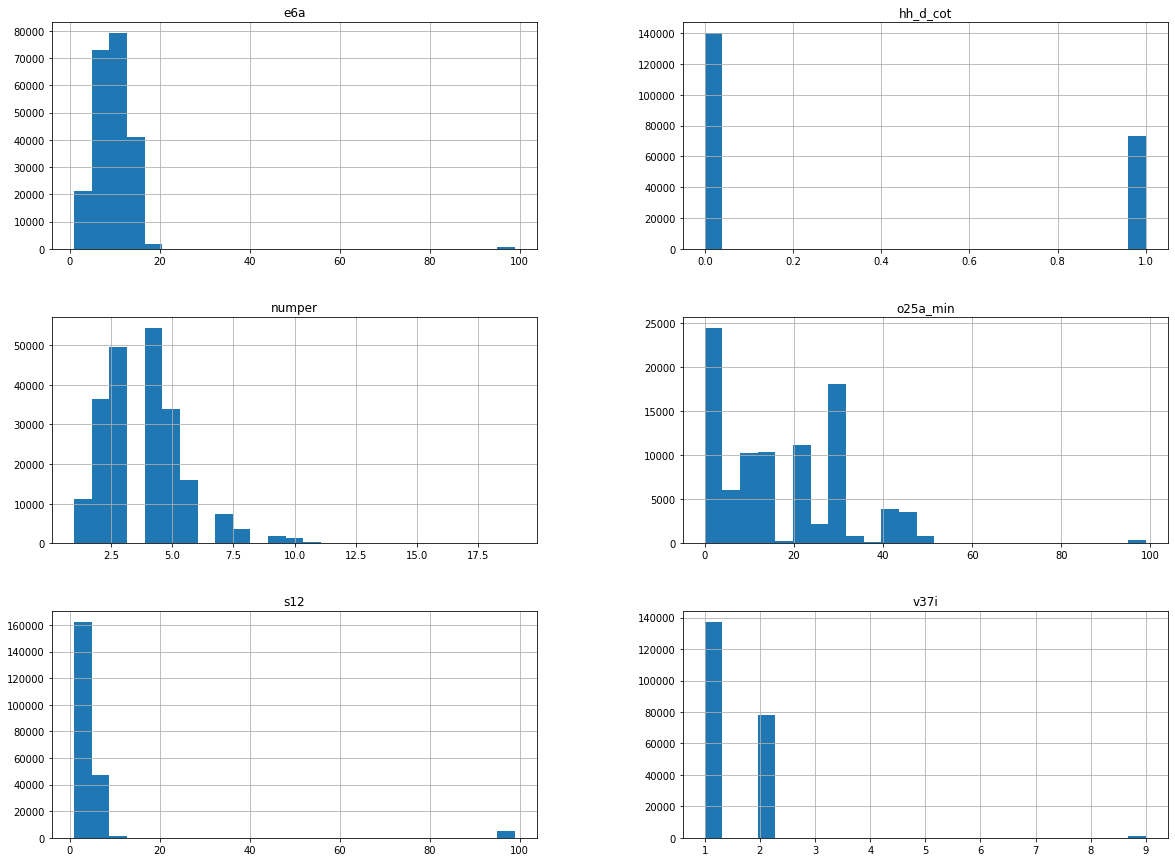

In [23]:
casen_rel_in.drop(['comuna'], axis = 1).hist(figsize = (20, 15), bins = 25)

16.794518324550676


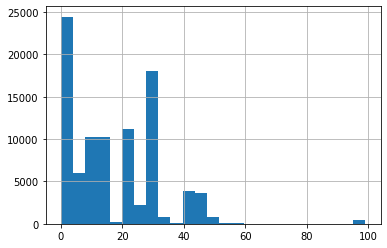

In [24]:
# The column o25a_min has a lot of NaNs, the mean commuting time is about 16 minutes. 
print(casen_rel_in['o25a_min'].mean())

casen_rel_in['o25a_min'].hist(bins = 25)

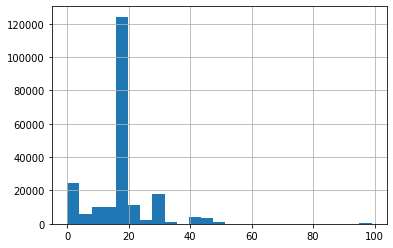

In [25]:
# Given that the NaNs could change the correlation, we fill them with the mean of the column. 
casen_rel_in['o25a_min'] = casen_rel_in['o25a_min'].fillna(casen_rel_in['o25a_min'].mean())

casen_rel_in['o25a_min'].hist(bins = 25)

AxesSubplot(0.125,0.125;0.775x0.755)


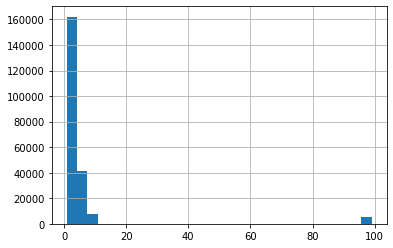

In [26]:
# The s12 column is also a very interesting case. It contains values between 1 and 7, where 1 is the 
# most basic health insurance system and 7 the most extensive system. However, 8 (no health insurance) and 9 
# (other system) do not provide more services than number 7, so its no continuous scale. 
print(casen_rel_in['s12'].hist(bins = 30))

In [27]:
# We have to add therefore more columns following the one hot encoding approach.
# With the get_dummies method, we can create some dummy columns for the different health insurance systems: 
casen_rel_most = pd.concat([casen_rel_in, pd.get_dummies(casen_rel_in['s12'])], axis = 1).drop(['s12'], axis = 1)

casen_rel_most.head()

,comuna,o25a_min,e6a,v37i,numper,hh_d_cot,1,2,3,4,5,6,7,8,9,99
0,1101,10.0,9,1,1.0,1.0,0,0,0,0,0,0,0,0,0,1
1,1101,10.0,7,2,1.0,1.0,0,0,0,0,0,0,0,1,0,0
2,1101,10.0,9,1,2.0,1.0,0,0,0,0,0,0,0,0,0,1
3,1101,10.0,9,1,2.0,1.0,0,0,0,0,0,0,0,0,0,1
4,1101,40.0,13,1,3.0,0.0,0,1,0,0,0,0,0,0,0,0


### C. Show correlation between six selected CASEN social indicators and cases/deaths for most affected districts regarding Covid-19 cases 

Now that we have the DataFrame with the prepared data (filled in the NaNs with o25a_min and one hot encoding for the health insurance system, we can call again the functions to show the correlations between those indicators and the Covid-19 cases/deaths in Chile. 

In [28]:
show_corr(cases_districts, casen_rel_most, 'cases', 10, 100)

cases           1.000000
o25a_min        0.516068
e6a             0.435387
s12             0.402924
v37c            0.399313
y22a            0.322742
v37i            0.306185
qaut            0.287048
y21a            0.273781
pobreza         0.235721
r7c             0.203988
o28             0.181085
ytot            0.180921
v37a            0.159378
y27a            0.138607
hh_d_prevs      0.134393
s32c            0.130090
o12             0.129488
comuna          0.087567
r3              0.084421
s27a            0.076282
o16             0.075799
s13             0.062497
hh_d_cot        0.045601
v33             0.012716
r1a            -0.017887
s33j1          -0.046481
s26a           -0.053524
s31a1          -0.062321
s28            -0.073180
numper         -0.103244
y24            -0.163694
r8a            -0.184736
r8b            -0.185869
s33g1          -0.187834
r16b           -0.204607
v39b           -0.204997
o25c           -0.206036
s33i1          -0.306285
o1             -0.315301


In [29]:
show_corr(deaths_districts, casen_rel_most, 'deaths', 10, 100)

deaths          1.000000
v37i            0.399373
r7c             0.274913
s32c            0.273172
s26a            0.258480
y27a            0.213629
y24             0.202281
o25a_min        0.184643
s14             0.182267
comuna          0.163795
hh_d_cot        0.156302
o12             0.130100
numper          0.116794
y21a            0.090534
o1              0.060356
y22a            0.032909
pobreza        -0.000052
s27a           -0.002438
v37c           -0.022792
v37a           -0.065911
qaut           -0.091451
s12            -0.093979
r8b            -0.099280
o16            -0.102503
e6a            -0.108563
r8a            -0.112184
s33j1          -0.125802
v33            -0.144309
r16a           -0.175860
e1             -0.176584
o28            -0.184188
ytot           -0.220872
s13            -0.238103
hh_d_prevs     -0.257869
r3             -0.265730
v39b           -0.267465
r16b           -0.277550
r1a            -0.337033
s33g1          -0.350169
s31a1          -0.380823


## <a class="anchor" id="part-iv">Part IV: Analyze the CASEN data: The ten less affected districts</a>

[Go to index](#head)

### A. Correlation between the CASEN social indicators and cases/deaths in the ten less affected districts

After a look at the ten most affected districts, we will take a look at the ten less affected districts and which are the CASEN indicators with the highest correlation. 

In [30]:
get_affected_districts(cases_districts, 'cases', -10, 100)

,District,Region,District ID,cases
0,Quinta de Tilcoco,O’Higgins,6114.0,112.0
1,Algarrobo,Valparaíso,5602.0,110.0
2,Rauco,Maule,7305.0,109.0
3,Villarrica,Araucanía,9120.0,106.0
4,Carahue,Araucanía,9102.0,105.0
5,El Carmen,Ñuble,16104.0,103.0
6,Pitrufquen,Araucanía,9114.0,103.0
7,Pemuco,Ñuble,16105.0,103.0
8,La Union,Los Ríos,14201.0,102.0
9,Rio Claro,Maule,7108.0,100.0


In [31]:
get_affected_districts(deaths_districts, 'deaths', -10, 20)

,District,Region,District ID,deaths
0,Quillota,Valparaiso,5501.0,35.0
1,Curico,Maule,7301.0,34.0
2,Talca,Maule,7101.0,32.0
3,Concepcion,Biobio,8101.0,28.0
4,Punta Arenas,Magallanes y la Antartica,12101.0,28.0
5,San Felipe,Valparaiso,5701.0,27.0
6,Pirque,Metropolitana,13202.0,26.0
7,Temuco,La Araucania,9101.0,24.0
8,Ovalle,Coquimbo,4301.0,21.0
9,La Serena,Coquimbo,4101.0,20.0


In [32]:
show_corr(cases_districts, casen_rel, 'cases', -10, 100).head()

cases       1.000000
s13         0.841504
ytot        0.765572
qaut        0.650472
o25a_min    0.597127
dtype: float64

In [33]:
show_corr(deaths_districts, casen_rel, 'deaths', -10, 100).head()

deaths          1.000000
s27a            0.585255
hh_d_servbas    0.478753
pobreza         0.459772
s26a            0.452553
dtype: float64

### B. A closer look at the indicators with the highest correlation for the ten less affected districts

The indicators that have the highest correlation with Covid-19 cases/deaths in Chile are: 
* s13: State of health
* ytot: Total household income
* qaut: National quintile

* r1a: Nationality (Chilean or not)
* v39b: Occurrence of contaminated air / bad smell


In [34]:
casen_rel_less = casen_rel[['r1a', 'v39b', 's13', 'ytot', 'qaut']]

print(first_look([casen_rel_less]))

Information for DataFrame casen_rel_less
The shape of this DataFrame is (216439, 5).
NaN share for each column:
r1a     0.000000
v39b    0.000000
s13     0.000000
ytot    0.331424
qaut    0.000961
dtype: float64
Describe() for each column:
                 r1a           v39b            s13          ytot  \
count  216439.000000  216439.000000  216439.000000  1.447060e+05   
mean        1.062743       1.566987       5.788883  4.039880e+05   
std         0.337036       0.938239       1.321671  7.838145e+05   
min         1.000000       1.000000       1.000000  8.300000e+01   
25%         1.000000       1.000000       5.000000  1.083300e+05   
50%         1.000000       1.000000       6.000000  2.700000e+05   
75%         1.000000       2.000000       7.000000  4.500000e+05   
max         3.000000       9.000000       9.000000  8.470000e+07   

                qaut  
count  216231.000000  
mean        2.741027  
std         1.366326  
min         1.000000  
25%         2.000000  
50%      

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C98CDBA6A0>,
      dtype=object)

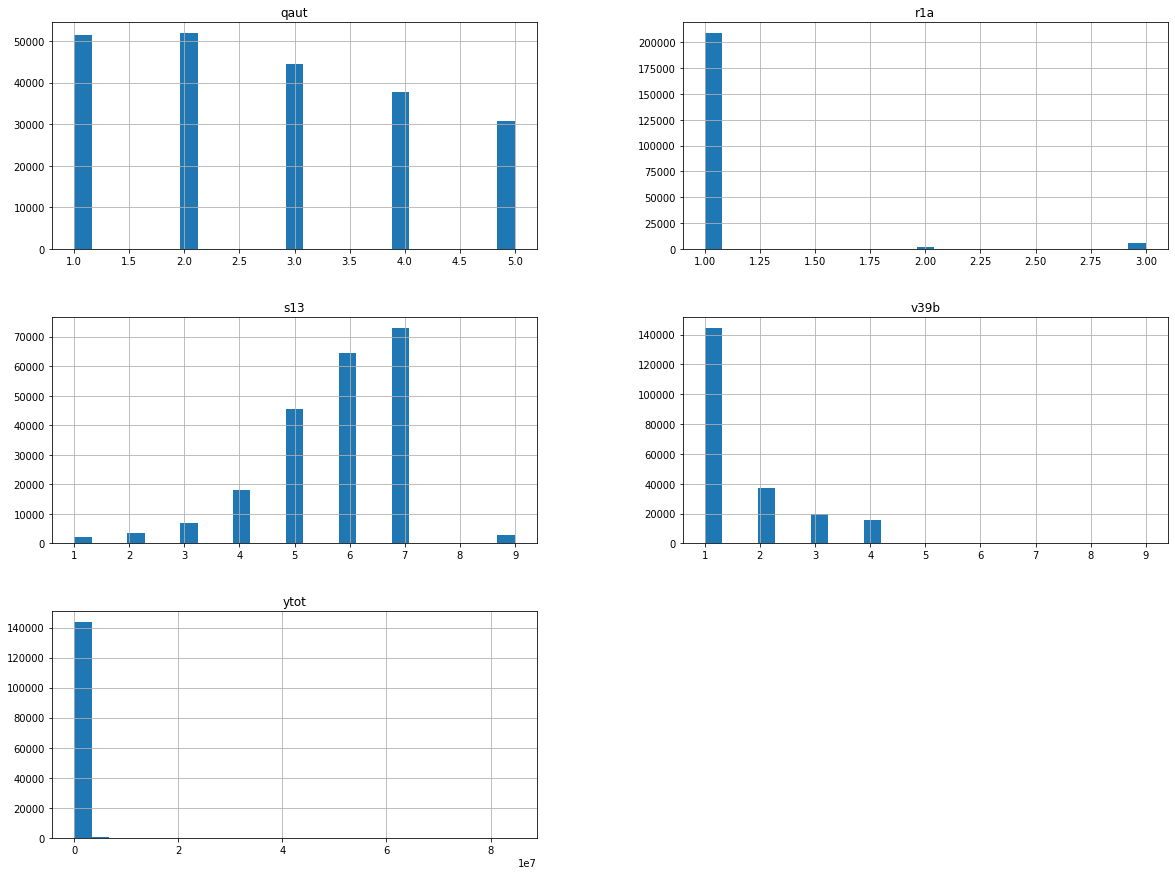

In [35]:
casen_rel_less.hist(figsize = (20, 15), bins = 25)

## <a class="anchor" id="part-v">Part V: Plot CASEN data vs. Covid-19 cases/deaths</a>

[Go to index](#head)

In this chapter, I would like to visualize the correlation between the cases/deaths of Covid-19 in Chile and selected CASEN social indicators. 

In [36]:
# First, we define a new DataFrame that includes the indicators with the 
# highest correlation for the 10 most and the 10 less affected districts. 

casen_rel_all = pd.concat([casen_rel_most, casen_rel_less], axis = 1)
casen_rel_all.head()

,comuna,o25a_min,e6a,v37i,numper,hh_d_cot,1,2,3,4,...,6,7,8,9,99,r1a,v39b,s13,ytot,qaut
0,1101,10.0,9,1,1.0,1.0,0,0,0,0,...,0,0,0,0,1,3,3,4,250000.0,3.0
1,1101,10.0,7,2,1.0,1.0,0,0,0,0,...,0,0,1,0,0,3,1,5,211091.0,3.0
2,1101,10.0,9,1,2.0,1.0,0,0,0,0,...,0,0,0,0,1,1,4,4,281750.0,4.0
3,1101,10.0,9,1,2.0,1.0,0,0,0,0,...,0,0,0,0,1,3,4,4,311750.0,4.0
4,1101,40.0,13,1,3.0,0.0,0,1,0,0,...,0,0,0,0,0,3,4,9,341667.0,2.0


### A. Scatterplot for Covid-19 cases

In [37]:
def plot_indicator_vs_affected(df, casen_data, title, m, m_2, n):
    """
    A function to plot a scatterplot of the number of cases/deaths of Covid-19 vs. a specific
    CASEN indicator. 
    
    Input:
        df (DataFrame): DataFrame to provide data about the affected districts
        casen_data (DataFrame): DataFrame with CASEN indicators should be considered
        title (string): Type of the above mentioned DataFrame (cases or deaths)
        m (int): Returns the m most affected districtse. If m == 0, it returns a sorted DataFrame of all districts.
        m_2 (int): Number of how many less affected districts you would like to have returned. 
                   If m == 0, it returns a sorted DataFrame of all districts.
        n: Threshold of number of cases/deaths for districts to be considered in the less affected districts
        
    Output:
        Seaborn subplots of cases vs. specific indicator. 
    
    """
    
    # Prepare one DataFrame with the 10 most and the 10 less affected districts
    df_plot = pd.concat([show_CASEN_for_districts(df, casen_data, title, m, n), 
                                show_CASEN_for_districts(df, casen_rel_all, title, m_2, n)], 
                              axis = 0).reset_index().drop(['index'], axis = 1)

    # Prepare figure
    fig = plt.figure(figsize = (10, 130))

    for item, i in zip(df_plot.columns, range(17)):
        
        # No scatterplot is needed for these categories
        if item not in ['comuna', 'District', 'Region', 'cases', '99']:

            # Add subplot at specific postition
            ax = fig.add_subplot(16, 1, i)

            # Plot the scatterplot
            sns.scatterplot(x = df_plot[item], y = df_plot[title], sizes = (150, 600), size = df_plot[title], hue = df_plot['Region'])
            plt.title('Scatterplot for {} vs. indicator: {}'.format(title, item))
            plt.ylabel(title)
            plt.xlabel('Indicator: {}'.format(item))
            ax.yaxis.grid()
            sns.despine()
            plt.legend(scatterpoints=1, frameon=True, labelspacing=1.5, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


    plt.show()

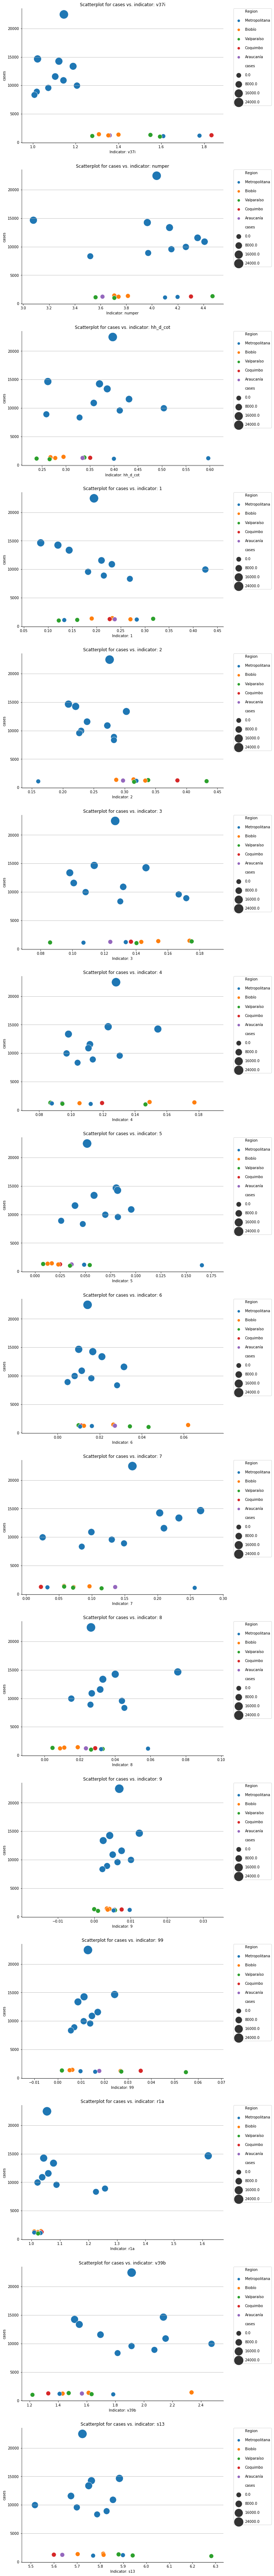

In [38]:
# To select the less affected districts, I chose a threshold of minimum 1000 cases:
plot_indicator_vs_affected(cases_districts, casen_rel_all, 'cases', 10, -10, 1000)

### B. Scatterplot for Covid-19 deaths

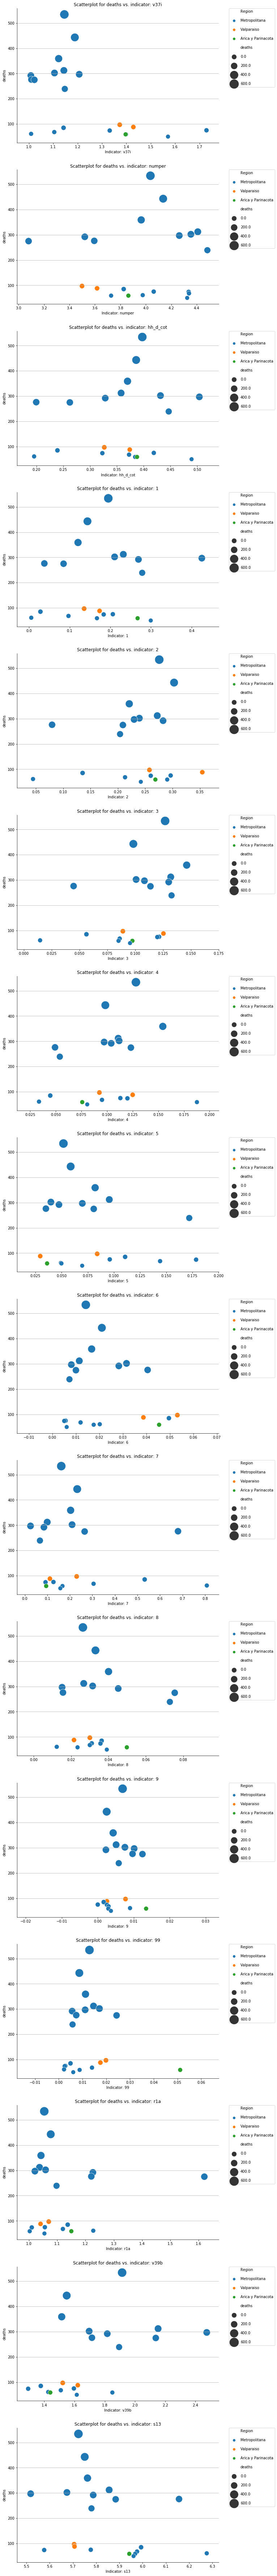

In [39]:
# To plot the deaths, I chose a threshold of 50 deaths caused by Covid-19:
plot_indicator_vs_affected(deaths_districts, casen_rel_all, 'deaths', 10, -10, 50)

## <a class="anchor" id="part-vi">Part VI: Predict Covid-19 cases/deaths applying a Machine Learning model to CASEN data</a>

[Go to index](#head)

In this part, we are going to apply a simple Machine Learning model to the CASEN data. We are going to try out the performance of KNeighborsRegressor (with different k values) and LinearRegression. 

We will compare the score values for both estimators and plot the relation between the predicted and the real values. 

In [177]:
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors

def create_model(df, casen_data, title, m=0, n=1000):
    
    """
    A function to create a Machine Learning model to predict cases and deaths only based on 
    the CASEN social indicators. 
    
    Input:
        df (DataFrame): DataFrame to provide data about the affected districts
        casen_data (DataFrame): DataFrame with CASEN indicators should be considered
        title (string): Type of the above mentioned DataFrame (cases or deaths)
        m (int): Returns the m most affected districts. If m == 0, it returns a sorted DataFrame of all districts,
                 which is recommended for this function.
        n: Threshold of number of cases/deaths for districts to be considered in the less affected districts. 
           In this function we recommend n=1000
        
    Output:
        Score (float): The score of the Machine Learning model.
        coef_df (DataFrame): A sorted DataFrame with all features sorted by their coefficients. 
        A Matplotlib scatterplot of the real values vs. the predicted values.  
        
    """

    # We drop all NaNs, which takes away about 50.000 rows (of course, here are other possibilities).
    casen_data_ml = casen_data.dropna()

    # Get X and y for LinearRegression model. We also create the DataFrame z to retrieve the 'Region' data
    X = show_CASEN_for_districts(df, casen_data_ml, title, m, n).drop(['District', 'Region', title, 'comuna'], axis = 1)
    y = show_CASEN_for_districts(df, casen_data_ml, title, m, n)[title]
    z = show_CASEN_for_districts(df, casen_data_ml, title, m, n)

    # Normalize the data
    min_max_scaler = preprocessing.MinMaxScaler()
    X_scaled = min_max_scaler.fit_transform(X)

    # Split the data into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)
    
    # Prepare DataFrame (using z) to match every index with a region. 
    df_merge = pd.merge(pd.DataFrame(y_test), pd.DataFrame(z[z.index.isin(y_test.index)]['Region']), left_index=True, right_index=True)

    # Train KNeighborsRessor and find best k: 
    acc = []
    for k in range(1,100):
        kneigh = neighbors.KNeighborsRegressor(n_neighbors=k)
        kneigh.fit(X_train, y_train)
        kneigh_score = kneigh.score(X_test, y_test)
        acc.append(kneigh_score)
        
    # Print the score and k for the best k. 
    print('The score of KNeighborsRegressor is highest with {} at k = {}.'.format(max(acc), acc.index(max(acc)) + 1))

    # Plot the search for the best k. 
    f, ax = plt.subplots(figsize = (12,8))
    plt.plot(range(1,100), acc)
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for different values of k in KNeighborsRegressor')
    plt.show()
    
    # Fit KNeighborsRegressor with best k. 
    kneigh_opt = neighbors.KNeighborsRegressor(n_neighbors=acc.index(max(acc)) + 1)
    kneigh_opt.fit(X_train, y_train)

    # Predict test data. 
    y_predict = kneigh_opt.predict(X_test)
    
    # Plot real values vs. predicted values. 
    f, ax = plt.subplots(figsize = (12,8))
    sns.scatterplot(y_predict, df_merge[title], sizes = (100, 500), size = df_merge[title], hue = df_merge['Region'], alpha = 0.8)
    plt.title('Prediction of Covid-19 {} with KNeighborsRegressor: Comparison of predicted values vs. real values'.format(title))
    plt.xlabel('y_predict: Predicted value')
    plt.ylabel('y_test: real value')
    plt.legend(scatterpoints=1, frameon=True, labelspacing=.5, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    # Train LinearRegression model and predict test values
    lr_model = LinearRegression().fit(X_train, y_train)
    y_predict= lr_model.predict(X_test)

    # Print the score for LinearRegression model
    print('The score of LinearRegression equals: {}'.format(lr_model.score(X_test, y_test)))

    # Plot scatterplot of predicted vs. true values
    f, ax = plt.subplots(figsize = (12,8))

    sns.scatterplot(y_predict, df_merge[title], sizes = (100, 500), size = df_merge[title], hue = df_merge['Region'], alpha = 0.8)
    plt.title('Prediction of Covid-19 {} with LinearRegression: Comparison of predicted values vs. real values'.format(title))
    plt.xlabel('y_predict: Predicted value')
    plt.ylabel('y_test: real value')
    plt.legend(scatterpoints=1, frameon=True, labelspacing=.5, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



The score of KNeighborsRegressor is highest with 0.5488034965145621 at k = 4.


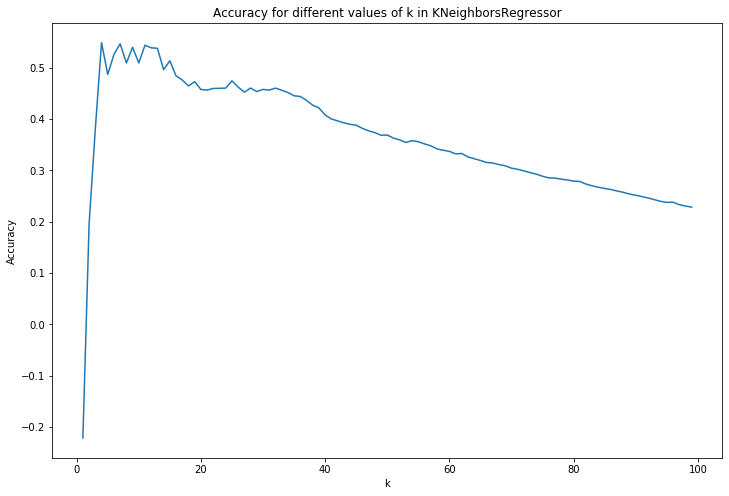

The score of LinearRegression equals: 0.4024046337318895


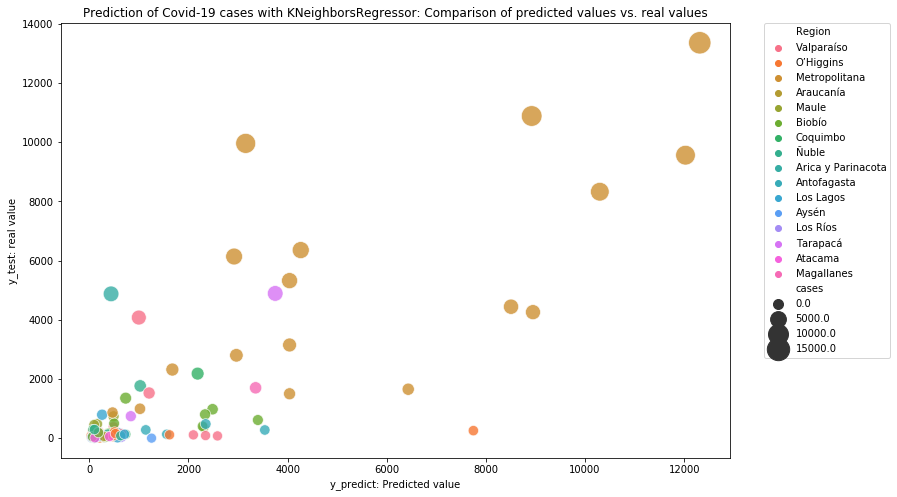

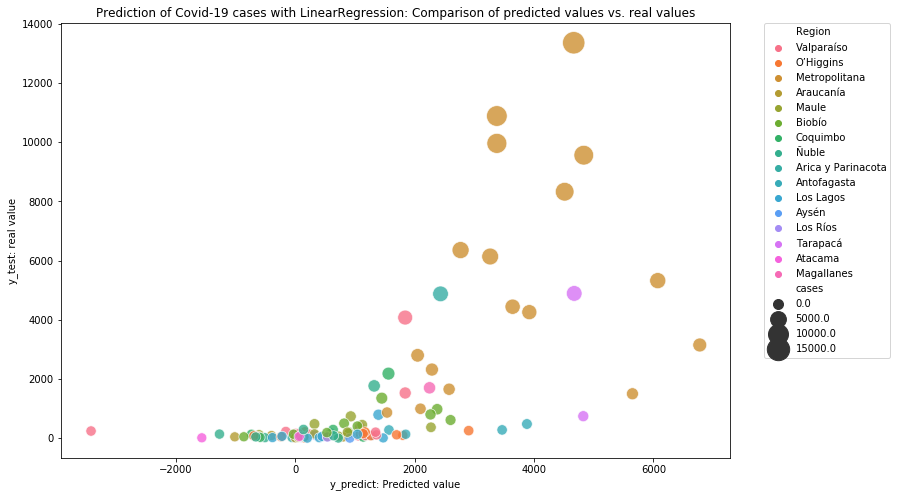

In [178]:
create_model(cases_districts, casen_rel_all, 'cases', m=0, n=1000)

The score of KNeighborsRegressor is highest with 0.5462695719820574 at k = 11.


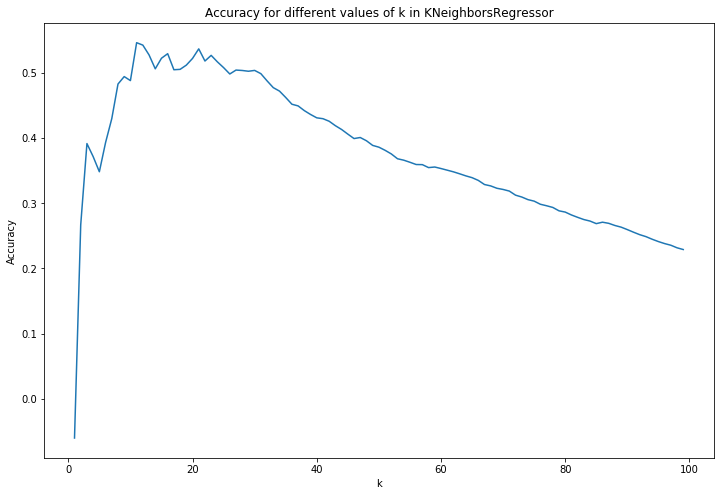

The score of LinearRegression equals: 0.30165318623821635


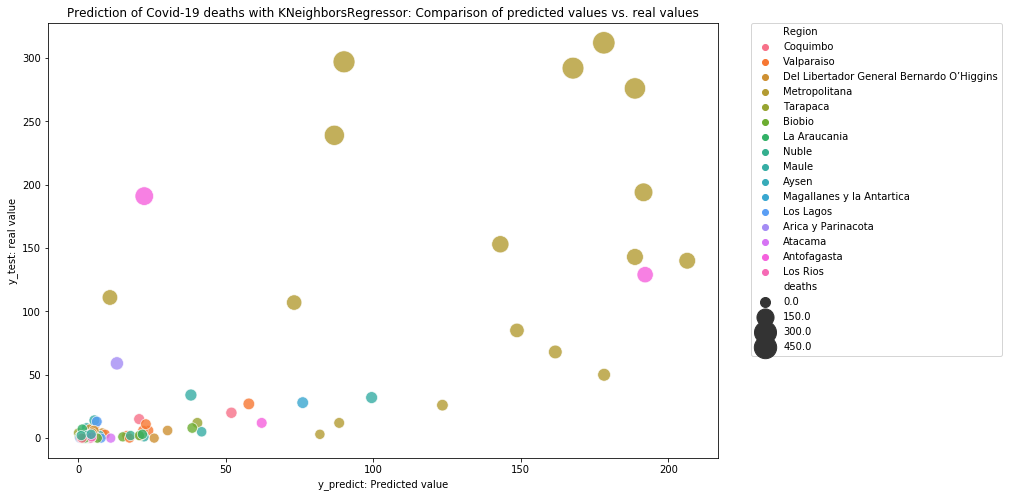

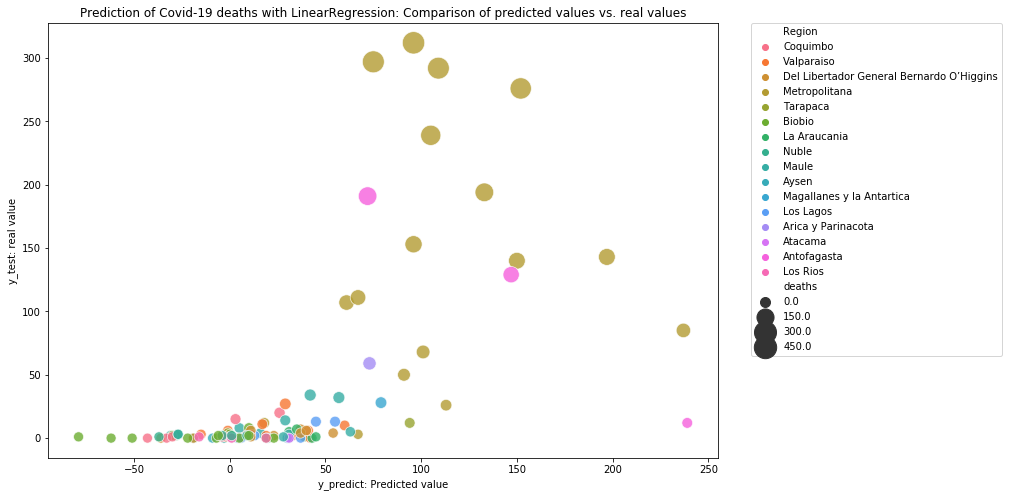

In [179]:
create_model(deaths_districts, casen_rel_all, 'deaths', m=0, n=1000)